# Transfer Learning
In this lab, you will see how you can use a pre-trained model to achieve good results even with a small training dataset. This is called transfer learning and you do this by leveraging the trained layers of an existing model and adding your own layers to fit your application. For example, you can:

<li> just get the convolution layers of one model
<li> attach some dense layers onto it
<li>train just the dense network
<li> evaluate the results
<br>
<br>
Doing this will allow you to save time building your application because you will essentially skip weeks of training time of very deep networks. You will just use the features it has learned and tweak it for your dataset. Let's see how these are done in the next sections.

# Setup the pretrained model
You will need to prepare pretrained model and configure the layers that you need. For this exercise, you will use the convolution layers of the InceptionV3 architecture as your base model. To do that, you need to:
<ol>
    <li> Set the input shape to fit your application. In this case. set it to 150x150x3 as you've been doing in the last few labs. </li>
    <br>
    <li> Pick and freeze the convolution layers to take advantage of the features it has learned already. </li>
    <br>
    <li> Add dense layers which you will train. </li>
</ol>

Let's see how to do these in the next cells.

First, in preparing the input to the model, you want to fetch the pretrained weights of the InceptionV3 model and remove the fully connected layer at the end because you will be replacing it later. You will also specify the input shape that your model will accept. Lastly, you want to freeze the weights of these layers because they have been trained already.

In [1]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-04 12:13:25--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.169.48, 142.250.179.240, 142.250.200.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.169.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  11.9MB/s    in 6.8s    

2022-06-04 12:13:32 (12.3 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
# taking the layers from an existing model and make them so that they don't get retrained (freeze)

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False,     # ignore the fully-connected layer at the top 
                                weights = None)          # don't want to use the built-in weights

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False               # freeze/lock the already learned convolutions

2022-06-04 12:13:34.536899: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-04 12:13:34.537008: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


You can see the summary of the model below. You can see that it is a very deep network. You can then select up to which point of the network you want to use. As Laurence (Course instructor) showed in the exercise, you will use up to `mixed_7` as your base model and add to that. This is because the original last layer might be too specialized in what it has learned so it might not translate well into your application. `mixed_7` on the other hand will be more generalized and you can start with that for your application. After the exercise, feel free to modify and use other layers to see what the results you get.

In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [4]:
# Choose `mixed_7` as the last layer of your base model which is the output of a lot of convolution that are 7 by 7.
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [5]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [6]:

# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

# Prepare the dataset
Now you will prepare the dataset. This is basically the same code as the one you used in the data augmentation lab.



In [7]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2022-06-04 12:13:36--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.169.48, 142.250.179.240, 142.250.200.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.169.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M  13.3MB/s    in 5.0s    

2022-06-04 12:13:41 (13.1 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



In [8]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20


2022-06-04 12:13:42.597130: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-04 12:13:43.304084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 12:13:51.008149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 - 10s - loss: 0.3378 - accuracy: 0.8690 - val_loss: 0.1013 - val_accuracy: 0.9640 - 10s/epoch - 100ms/step
Epoch 2/20
100/100 - 9s - loss: 0.2040 - accuracy: 0.9170 - val_loss: 0.1300 - val_accuracy: 0.9510 - 9s/epoch - 85ms/step
Epoch 3/20
100/100 - 9s - loss: 0.1792 - accuracy: 0.9325 - val_loss: 0.1761 - val_accuracy: 0.9470 - 9s/epoch - 89ms/step
Epoch 4/20
100/100 - 9s - loss: 0.1745 - accuracy: 0.9335 - val_loss: 0.0984 - val_accuracy: 0.9650 - 9s/epoch - 85ms/step
Epoch 5/20
100/100 - 9s - loss: 0.1664 - accuracy: 0.9330 - val_loss: 0.1241 - val_accuracy: 0.9610 - 9s/epoch - 85ms/step
Epoch 6/20
100/100 - 9s - loss: 0.1604 - accuracy: 0.9390 - val_loss: 0.1468 - val_accuracy: 0.9640 - 9s/epoch - 85ms/step
Epoch 7/20
100/100 - 9s - loss: 0.1722 - accuracy: 0.9365 - val_loss: 0.0943 - val_accuracy: 0.9680 - 9s/epoch - 85ms/step
Epoch 8/20
100/100 - 9s - loss: 0.1304 - accuracy: 0.9490 - val_loss: 0.1320 - val_accuracy: 0.9650 - 9s/epoch - 86ms/step
Epoch 9/20
100/100 - 9s 

# Evaluate the results
You will use the same code to plot the results. As you can see, the validation accuracy is also trending upwards as your training accuracy improves. This is a good sign that your model is no longer overfitting!

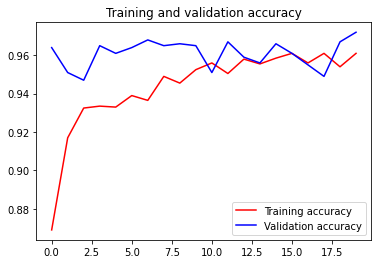

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## Solving the overfitting

Another useful tool to explore at this point is the **Dropout**. 

The idea behind it is to remove a random number of neurons in your neural network. This works very well for two reasons: The first is that neighboring neurons often end up with similar weights, which can lead to overfitting, so dropping some out at random can remove this. The second is that often a neuron can over-weigh the input from a neuron in the previous layer, and can over specialize as a result. Thus, dropping out can break the neural network out of this potential bad habit! 

In [11]:
# taking the layers from an existing model and make them so that they don't get retrained (freeze)

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False,     # ignore the fully-connected layer at the top 
                                weights = None)          # don't want to use the built-in weights

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False               # freeze/lock the already learned convolutions

In [12]:
# Choose `mixed_7` as the last layer of your base model which is the output of a lot of convolution that are 7 by 7.
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


# Add dense layers for your classifier
Next, you will add dense layers to your model. These will be the layers that you will train and is tasked with recognizing cats and dogs. You will add a Dropout layer as well to regularize the output and avoid overfitting.

In [13]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)



# Add a dropout rate of 0.2. Drop the random neurons from the hidden layers
# dropping 20 % of our neurons
x = layers.Dropout(0.2)(x)                  



# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [14]:

# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [15]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20


2022-06-04 12:16:38.759530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 12:16:46.530856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 - 10s - loss: 0.3451 - accuracy: 0.8620 - val_loss: 0.1043 - val_accuracy: 0.9610 - 10s/epoch - 102ms/step
Epoch 2/20
100/100 - 8s - loss: 0.2312 - accuracy: 0.9195 - val_loss: 0.0896 - val_accuracy: 0.9640 - 8s/epoch - 85ms/step
Epoch 3/20
100/100 - 8s - loss: 0.1849 - accuracy: 0.9335 - val_loss: 0.1843 - val_accuracy: 0.9390 - 8s/epoch - 84ms/step
Epoch 4/20
100/100 - 8s - loss: 0.1982 - accuracy: 0.9250 - val_loss: 0.1159 - val_accuracy: 0.9640 - 8s/epoch - 85ms/step
Epoch 5/20
100/100 - 8s - loss: 0.1683 - accuracy: 0.9335 - val_loss: 0.2159 - val_accuracy: 0.9370 - 8s/epoch - 84ms/step
Epoch 6/20
100/100 - 9s - loss: 0.1857 - accuracy: 0.9350 - val_loss: 0.0971 - val_accuracy: 0.9740 - 9s/epoch - 86ms/step
Epoch 7/20
100/100 - 9s - loss: 0.1526 - accuracy: 0.9460 - val_loss: 0.1116 - val_accuracy: 0.9650 - 9s/epoch - 87ms/step
Epoch 8/20
100/100 - 9s - loss: 0.1812 - accuracy: 0.9340 - val_loss: 0.1247 - val_accuracy: 0.9620 - 9s/epoch - 86ms/step
Epoch 9/20
100/100 - 9s 

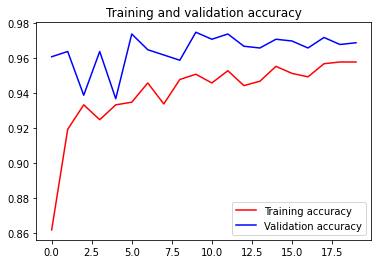

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()